<a href="https://colab.research.google.com/github/johannes-kk/am207/blob/master/exercises/13_hierarchical_GLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAY 13: Interpreting and Evaluating Hierarchical General Linear Models


### AM207: Advanced Scientific Computing

#### Instructor: Weiwei Pan

#### Due: October 15th, 11:59pm EST

**Names of Group Members**: Jason Lee, Mingyue Wei, Yichen Geng, Yingsi Jian, Kofi Kwapong, Ryan Kim, Johannas Kolberg


## Learning Goals:

1. Practice using `pymc3` for model building and inference
2. Practice performing model selection using information criteria
2. Explore the subleties of model interpretation using model selection (what conclusions can we safely draw from our fitted models?)


### Load necessary libraries

In [ ]:
### Import basic libraries
import numpy as np
import pandas as pd
import sklearn as sk
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline

## Problem Description: A Study of Census Data

In this problem, you are given the data for the 1994 U.S. Census. The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Census+Income)). 

You will be investigate the effect of the marital status on a person's yearly income in the dataset. In particular, we want to know how a person's marital status affect the likelihood of their yearly salary being above or below \$50k. 

This analysis is a direct replica of the one in Example 10.1.3 in "Statistical Rethinking" (the excerpt of which is included in reading for this week). Example 10.1.3 illustrates a study of the effect of an applicant's gender on graduate school admissions to six U.C. Berkeley departments through a comparison of four models. 

The data you've been given has been aggregate into seven different categories. The categories represent: 

- Category 1: 4 year college degree
- Category 2: Some-college or two year academic college degree
- Category 3: Professional or vocational school degree
- Category 4: High school degree
- Category 5: Did not complete high school
- Category 6: Masters 
- Category 7: Doctorate


For each category, we've only kept track of a count of the number of maried and unmarried individuals who make above (and resp. below) \\$50k and the total number of people in the category. 


### Part I: Analysis of the Effect of Marital Status

You will build two models to predict an individual's yearly income (1 being above \\$50k and 0 being below), one of these models should include the effect of marital status while the other should not.

**Model 1 (Includes Marital Information):** Let $Y_n$ be the number of individuals in the $n$-th observation that earns above \\$50k and let $M_n$ be a binary indicator of the marital status of the $n$-th observation (1 indicates "married" and 0 otherwise).

\begin{aligned}
\beta &\sim \mathcal{N}(0, 10)\\
\alpha &\sim \mathcal{N}(0, 10)\\
\theta_n &= \text{sigm}(\alpha + \beta M_n)\\
Y_n &\sim Bin(T_n, \theta_n)
\end{aligned}

**Model 2 (Excludes Marital Information):** Let $Y_n$ be the number of individuals in the $n$-th observation that earns above \\$50k.

\begin{aligned}
\alpha &\sim \mathcal{N}(0, 10)\\
\theta_n &= \text{sigm}(\alpha)\\
Y_n &\sim Bin(T_n, \theta_n)
\end{aligned}

**Exercise 1:** Implement Model 1 and Model 2 in `pymc3`. To implement a mathematical function $a = f(b)$ in `pymc3`, you must use `a = pymc3.Deterministic('a', [your pymc3 implementation of f])`, where $f$ is implemented using `pymc3.math` functions.

  Compute the advantage or disadvantage of being married for high earning in terms of odds.

  Perform a WAIC comparison for the two models -- use `pymc3.waic`. 
  
  Based on the above, make a hypothesis about the effect of an individual's marital status on their income. 

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/onefishy/am207/master/Labs/datasets/census_data.csv')
df.head(n=14)

,category,married,total,<=50,>50
0,1,0,1619,1280,339
1,1,1,3736,1854,1882
2,2,0,3227,2974,253
3,2,1,5131,3732,1399
4,3,0,592,483,109
5,3,1,1366,691,675
6,4,0,3390,3164,226
7,4,1,7111,5662,1449
8,5,0,1321,1298,23
9,5,1,2932,2711,221


In [ ]:
df.shape

(14, 5)

In [ ]:
#total number of individuals in n-th observation
n = df['total'].values
#number of married individuals in the n-th observation
x = df['married'].values
#number of individuals with income above 50k in the n-th observation
y_obs = df['>50'].values
#category of the n-th observation
category = df['category'].values - 1

# model 1
#define model with marital status in pymc3
with pm.Model() as marital_model:
    #define priors
    alpha = pm.Normal('alpha', mu=0, tau=1./10)
    beta = pm.Normal('beta', mu=0, tau=1./10)
    #define linear model, using marital status as a covariate
    mu = alpha + pm.math.dot(x, beta) 
    #transform linear model into a probability
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))

    #define binomial likelihood
    y = pm.Binomial('y_obs', n=n, p=theta, observed=y_obs)

    #sample from the posterior using 3 HMC (No-U-Turn HMC) chains, 2000 samples per chain, 
    #using 6000 samples to tune the sampler, discarding the tuning samples
    trace_marital = pm.sample(4000, chains=3, tune=8000, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [beta, alpha]
100%|██████████| 12000/12000 [00:13<00:00, 897.22it/s]


In [ ]:
# pm.traceplot(trace_marital)
# plt.show()

In [ ]:
# pm.autocorrplot(trace_marital)
# plt.show()

In [ ]:
trace_marital_thinned = trace_marital[::40]

In [ ]:
print('marital advantage:', np.exp(trace_marital_thinned['beta'].mean(axis=0)))

marital advantage: 3.585895363712837


In [ ]:
#define model without marital status in pymc3
with pm.Model() as nonmarital_model:
    #define priors
    alpha = pm.Normal('alpha', mu=0, tau=1./10)
    #transform linear model into a probability
    theta = pm.Deterministic('theta', pm.math.sigmoid(alpha))

    #define binomial likelihood
    y = pm.Binomial('y_obs', n=n, p=theta, observed=y_obs)

    trace_nonmarital = pm.sample(4000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]
100%|██████████| 6000/6000 [00:03<00:00, 1924.87it/s]


In [ ]:
trace_nonmarital_thinned = trace_nonmarital[::20]

In [ ]:
# pm.traceplot(trace_nonmarital)
# plt.show()

In [ ]:
# pm.autocorrplot(trace_nonmarital)
# plt.show()

In [ ]:
marital_model.name = 'marital model'
nonmarital_model.name = 'nonmarital model'
df_comp_WAIC = pm.compare({marital_model: trace_marital_thinned, nonmarital_model: trace_nonmarital_thinned})
df_comp_WAIC

/usr/local/lib/python3.6/dist-packages/pymc3/stats.py:558: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ics.append((n, ic_func(t, m, pointwise=True)))
/usr/local/lib/python3.6/dist-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/usr/local/lib/python3.6/dist-packages/pymc3/stats.py:558: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ics.append((n, ic_func(t, m, pointwise=True)))
/usr/local/lib/python3.6/dist-packages/pymc3/stats.py:219: Use

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
marital model,4606.52,443.83,0,0.52,1171.7,0,1
nonmarital model,6250.36,416.06,1643.84,0.48,1607.78,1390.65,1


  Based on the above, make a hypothesis about the effect of an individual's marital status on their income. 

The marital model is more complex but the gain in predictive performance outweighs the penalisation for this additional complexity, as evidenced by the lower AIC. Therefore we can hypothesize that marital status has a strong effect on the subject’s income.

**Exercise 2:**  Make a plot like Figure 10.5 to perform a posterior predictive check (see how well your models fits the data). Specifically, for each category: 
  - plot the observed percentage of married individuals making over \$50k and unmarried individuals making over \$50k.
  - on the same plot, plot the posterior mean and posterior 95\% predictive interval (in percentages) of married individuals making over \$50k and unmarried individuals making over \$50k.
  
  Based on your posterior predictive check, are you more or less confident in the validity of your hypothesis regarding the relationship between marital status and income?

Broadly, we hypothesized that martial status certainly may drive income level; however, once we consider the education level of individuals, we observe that the share of individuals with incomes greater than a particular threshold is also related with those individuals’ education level. Therefore, we may adjust our hypothesis to say that income relies upon education level in addition to marital status. If given more information, we may be able to parse the collinearity between marital status and education level, however, that may be outside the scope of the question.

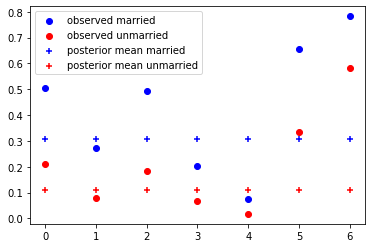

In [ ]:
theta_means = trace_marital_thinned['theta'].mean(axis=0)
theta_ub = np.percentile(trace_marital_thinned['theta'], 97.5, axis=0)
theta_lb = np.percentile(trace_marital_thinned['theta'], 2.5, axis=0)

plt.scatter(category[x==1], y_obs[x==1] * 1. / n[x==1], color='blue', label='observed married')
plt.scatter(category[x==0], y_obs[x==0] * 1. / n[x==0], color='red', label='observed unmarried')
plt.scatter(category[x==1], theta_means[x==1] * 1., color='blue', marker='+', label='posterior mean married')
plt.scatter(category[x==0], theta_means[x==0] * 1., color='red', marker='+', label='posterior mean unmarried')
plt.legend(loc='upper left')
plt.show()

### Part II: Analysis of the Effect of Marital Status Given Education

You will build two models to predict an individual's yearly income taking into account an individual's education. You can do this by modeling the effect of marital status with a coefficient $\beta$ and modeling the effect of each category $k$ of education with a coefficient $\alpha_k$, where $k=1, \ldots, 7$.

**Model 1 (Includes Marital Information):** Let $Y_n$ be the number of individuals in the $n$-th observation that earns above \\$50k, let $M_n$ be a binary indicator of the marital status of the $n$-th observation (1 indicates "married" and 0 otherwise), and let $Z_n$ be the education category for the $n$-th observation.

\begin{aligned}
\beta &\sim \mathcal{N}(0, 10)\\
\alpha_{Z_n} &\sim \mathcal{N}(0, 10)\\
\theta_n &= \text{sigm}(\alpha_{Z_n} + \beta M_n)\\
Y_n &\sim Bin(T_n, \theta_n)
\end{aligned}

**Model 2 (Excludes Marital Information):** Let $Y_n$ be the number of individuals in the $n$-th observation that earns above \\$50k and let $Z_n$ be the education category for the $n$-th observation.

\begin{aligned}
\alpha_{Z_n} &\sim \mathcal{N}(0, 10)\\
\theta_n &= \text{sigm}(\alpha_{Z_n})\\
Y_n &\sim Bin(T_n, \theta_n)
\end{aligned}

**Exercise 3:** Implement Model 1 and Model 2 in `pymc3`. 
  
  Compute the advantage for each category of education for high earning in terms of odds. Do these odds match your intuition about how education level affects earning?

  Compute the advantage or disadvantage of being married for high earning in terms of odds.
  
  Perform a WAIC comparison for the two models -- use `pymc3.waic`. 
  
  Based on the above, are you more or less confident in the validity of your hypothesis regarding the relationship between marital status and income?

In [ ]:
# model 1
#total number of individuals in n-th observation
n = df['total'].values
#number of married individuals in the n-th observation
x = df['married'].values
#number of individuals with income above 50k in the n-th observation
y_obs = df['>50'].values
#category of the n-th observation
category = df['category'].values - 1

# model 1
#define model with marital status in pymc3
with pm.Model() as marital_model:
    #define priors
    alpha = pm.Normal('alpha', mu=0, tau=1./10, shape=7)
    beta = pm.Normal('beta', mu=0, tau=1./10)
    #define linear model, using marital status as a covariate
    mu = alpha[category] + pm.math.dot(x, beta) 

    #transform linear model into a probability
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))

    #define binomial likelihood
    y = pm.Binomial('y_obs', n=n, p=theta, observed=y_obs)

    #sample from the posterior using 3 HMC (No-U-Turn HMC) chains, 2000 samples per chain, 
    #using 6000 samples to tune the sampler, discarding the tuning samples
    trace_marital = pm.sample(4000, chains=3, tune=8000, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [beta, alpha]
100%|██████████| 12000/12000 [00:17<00:00, 693.20it/s]


In [ ]:
trace_marital_thinned = trace_marital[::40]
print('marital advantage:', np.exp(trace_marital_thinned['beta'].mean(axis=0)))

marital advantage: 3.948255479741487


In [ ]:
# model 2
#define model with marital status in pymc3
with pm.Model() as nonmarital_model:
    #define priors
    alpha = pm.Normal('alpha', mu=0, tau=1./10, shape=7)
    #define linear model, using marital status as a covariate
    mu = alpha[category]

    #transform linear model into a probability
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))

    #define binomial likelihood
    y = pm.Binomial('y_obs', n=n, p=theta, observed=y_obs)

    #sample from the posterior using 3 HMC (No-U-Turn HMC) chains, 2000 samples per chain, 
    #using 6000 samples to tune the sampler, discarding the tuning samples
    trace_nonmarital = pm.sample(4000, chains=3, tune=8000, discard_tuned_samples=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [alpha]
100%|██████████| 12000/12000 [00:09<00:00, 1260.42it/s]


In [ ]:
trace_nonmarital_thinned = trace_nonmarital[::40]


In [ ]:
marital_model.name = 'marital model'
nonmarital_model.name = 'nonmarital model'
df_comp_WAIC = pm.compare({marital_model: trace_marital_thinned, nonmarital_model: trace_nonmarital_thinned})
df_comp_WAIC

/usr/local/lib/python3.6/dist-packages/pymc3/stats.py:558: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ics.append((n, ic_func(t, m, pointwise=True)))
/usr/local/lib/python3.6/dist-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/usr/local/lib/python3.6/dist-packages/pymc3/stats.py:558: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ics.append((n, ic_func(t, m, pointwise=True)))
/usr/local/lib/python3.6/dist-packages/pymc3/stats.py:219: Use

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
marital model,123.58,6.29,0,1,5.84,0,1
nonmarital model,2892.87,687.36,2769.29,0,611.18,608.07,1



The comparison we see above is similar to our comparison from part 1, as the marital model performs much better than the nonmarital model, shown by the much lower WAIC. So we reason that our hypothesis is supported by this updated model.

**Exercise 4:** Make a plot like Figure 10.5 to perform a posterior predictive check (see how well your models fits the data). Specifically, for each category: 
  - plot the observed percentage of married individuals making over \$50k and unmarried individuals making over \$50k.
  - on the same plot, plot the posterior mean and posterior 95\% predictive interval (in percentages) of married individuals making over \$50k and unmarried individuals making over \$50k.
  
  Based on your posterior predictive check, are you more or less confident in the validity of your hypothesis regarding the relationship between marital status and income?

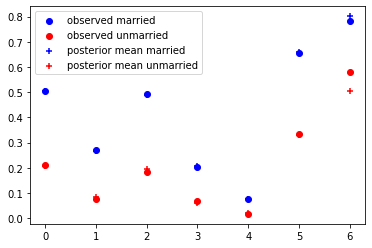

In [ ]:
theta_means = trace_marital_thinned['theta'].mean(axis=0)
theta_ub = np.percentile(trace_marital_thinned['theta'], 97.5, axis=0)
theta_lb = np.percentile(trace_marital_thinned['theta'], 2.5, axis=0)

plt.scatter(category[x==1], y_obs[x==1] * 1. / n[x==1], color='blue', label='observed married')
plt.scatter(category[x==0], y_obs[x==0] * 1. / n[x==0], color='red', label='observed unmarried')
plt.scatter(category[x==1], theta_means[x==1] * 1., color='blue', marker='+', label='posterior mean married')
plt.scatter(category[x==0], theta_means[x==0] * 1., color='red', marker='+', label='posterior mean unmarried')
plt.legend(loc='upper left')
plt.show()

**Exercise 5:** Based on your analysis above, what can you say about the effect of marital status on an individual's income? Point to evidence that supports what you are claiming.